# Entdecken von Malaria in Zellen

Autor: J. Kohl in 09/2020, Updates in 10/2021.

Teile dieses Notebooks sind entnommen aus:
* https://opensource.com/article/19/4/detecting-malaria-deep-learning
* [Keras-Dokumentation](https://www.tensorflow.org/guide/keras/sequential_model://)
* [Tensorflow-Dokumentation](https://www.tensorflow.org/api_docs/python/tf/all_symbols)
* https://towardsdatascience.com/convolutional-neural-network-feature-map-and-filter-visualization-f75012a5a49c
* https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/


## Problem statement

Klassifikation ob eine Zelle mit Malaria infiziert wurde oder nicht. 
Zusätzlich Vergleich zwischen der Genauigkeit eines selbst gebauten CNN-Netzes sowie bekannter Transfer Learning Ansätze.

## Daten organisieren

Wir laden uns zuerst die Malaria-Bilder aus einem Verzeichnis auf unseren Google Colab-Account hoch.
Dabei wird ein Verzeichnis /cell-images/ angelegt mit folgender Unterstruktur:
* Parasitized: infizierte Zellen
* Uninfected: gesunde Zellen

In [ ]:
#!wget ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/cell_images.zip
!wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
!unzip cell_images.zip

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_116.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_222.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_87.png  
 extracting: cell_images/Uninfected/C236Thi

In [ ]:
# Standardlibraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import os
import glob 

INFECTED_DIR = '/content/cell_images/Parasitized'
HEALTHY_DIR = '/content/cell_images/Uninfected'

infected_files = glob.glob(INFECTED_DIR + '/*.png')
healthy_files  = glob.glob(HEALTHY_DIR + '/*.png')

print(len(infected_files), "Dateien mit Bildern infizierter Zellen")
print(len(healthy_files), "Dateien mit Bildern gesunder Zellen")

13779 Dateien mit Bildern infizierter Zellen
13779 Dateien mit Bildern gesunder Zellen


## Data Exploration

Wir öffnen aus beiden Verzeichnissen zufällige Dateien und schauen diese uns an. Zusätzlich interessiert uns auch die Struktur der Bilder, da wir ja nach Mustern suchen

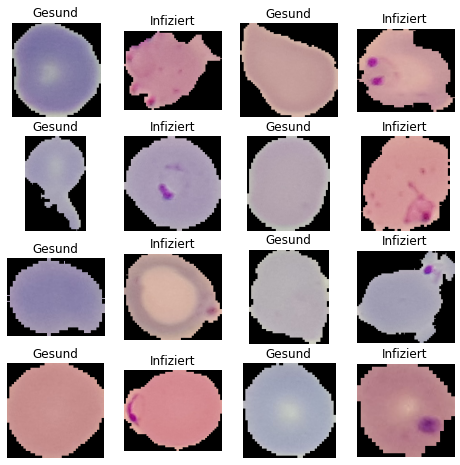

In [ ]:
import numpy as np
%matplotlib inline

number_cols = 4
number_rows = 4
run_index = 0

plt.figure(1 , figsize = (8 , 8))

for i in range(number_cols * number_rows):
  run_index += 1
  cur_plot = plt.subplot(number_cols, number_rows, run_index)

  if run_index % 2 == 0:
    plt.title('Infiziert')
    img = plt.imread(np.random.choice(infected_files)) # wähle ein zufälliges Bild aus der Menge der Bilder mit infizierten Zellen
  else:
    plt.title('Gesund')
    img = plt.imread(np.random.choice(healthy_files)) # wähle ein zufälliges Bild aus der Menge der Bilder mit gesunden Zellen

  plt.imshow(img)
  cur_plot.axis('Off') # Keine Achsen zeigen
  
plt.show()

Wenn man sich nur die zufällig ausgesuchten Bilder anschaut, könnte man vermuten, daß die rötlich gefärbten Kreise Malaria anzeigen.

Da man nie wissen kann, an welcher Stelle in der Zelle die so sind, muß man Algorithmen einsetzen, die Strukturen in den Bildern erkennen statt anhand einzelner, fixer Bildpunkte.

Genau das machen die Faltungsoperatoren in einem CNN.

## Data management

Wir haben jetzt 2 Möglichkeiten das Training vorzubereiten:
* Methode 1: wir nehmen die Daten direkt und teilen auf. Das Label kennen wir ja anhand Verzeichnisnamen
* Methode 2: wir nutzen das sogenannte **Data Augmentation**-Verfahren, das  die Bibliotheks-Funktionen von KERAS, unserer hier eingesetzten Machine Learning Library anbietet. 

Die Idee von Data Augmentation ist, verschiedenste Operationen wie Drehen, Farben ändern, verzerren, etc. auf die Trainingsbilder anzuwenden. Dies ermöglicht zum Einen, mehr Trainingsbilder zu generieren für ein besseres Lernen (so können wir auch Machine Learning auf wenige Bilder starten). 
Zum Anderen aber macht Data Augmentation unser Modell deutlich robuster, weil es durch die vielen leichten Veränderungen das Modell dazu zwingt, diese Veränderungen als mögliche Varianz zu lernen und so mehr zu generalisieren.

Methode 2 empfiehlt sich eigentlich immer, vor allem wenn wir unsere Modelle auch in der Praxis einsetzen wollen.

Der einzige Nachteil (neben längerer Trainingsphase ist), daß wir eine spezifische Verzeichnisstruktur brauchen.

Die Verzeichnisstruktur ist dabei immer gleich: es gibt je einen Ordner für Trainings-, Validierungs- und Testdaten. In jedem dieser Ordner ist dann eine Unterordnerstruktur, die die Anzahl und Namen der Zielklassen abbildet und die jeweiligen passenden Bilder enthält.. 
In unserem Fall Infiziert oder gesund gibt es somit in den Ordnern Train, Val und Test jeweils 2 Unterordner "Infiziert" und "gesund".

Wir müssen also die gesamte Anzahl Bilder für infizierte und gesunde Zellen gemäß der Klasse aufteilen und dann erneut in das bekannte Verhältnis Train zu Val zu Test.

Dies erledigt die Bibliotheksfunktion Splitfolders praktischerweise für uns

In [ ]:
!pip install split-folders tqdm
import splitfolders

input_folder = '/content/cell_images'
splitfolders.ratio(input_folder, output="output", seed=1337, ratio=(.6, .2, .2), group_prefix=None)

Copying files: 27560 files [00:06, 4375.20 files/s]


In dieser Zeile schauen wir uns genauer Data Augmentation an: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

Sie können mit den Parametern gerne experimentieren. Wichtig ist aber, daß Sie die Normalisierung per rescale drinnen haben (rescale=1./255) und zwar bei Train, Test und Validation Generator!

Stellen Sie sich das so vor, wie wenn Sie verschiedenste Audio-Dateien in unterschiedlicher Lautstärke haben und manche Lieder zu laut und andere dafür zu leise sind. Wenn Sie eine einheitliche Lautstärke haben, brauchen Sie nicht regelmäßig die Lautstärke manuell anpassen.

Weiterhin wichtig ist daß Sie für die Validierungs- und Testmenge nur die Bilder normalisieren und shuffeln (damit nicht immer die gleichen Bilder zum Testen genommen werden). Sonst KEINE Augmentation, da Sie ja sonst die realen Bilder verzerren.

Ein weiterer Punkt: schauen Sie bei der Textausgabe dieser Zelle wie viele Bilder je Generator gefunden wurden. Die Zahl sollte schon deutlich, deutlich über 1000 liegen.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_image_gen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

test_image_gen = ImageDataGenerator(rescale=1./255)

train_generator = train_image_gen.flow_from_directory(
    "/content/output/train", 
    target_size=(150, 150),  # Alle Bilder haben Einheitsgröße 150 x 150
    color_mode = 'rgb',
    batch_size=256,
    class_mode='binary',
    shuffle=True)

validation_generator = test_image_gen.flow_from_directory(
    "/content/output/val", 
    target_size=(150, 150),
    batch_size=256,
    color_mode = 'rgb',
    class_mode='binary',
    shuffle=True)

test_generator = test_image_gen.flow_from_directory(
     "/content/output/test", 
     target_size=(150, 150),
     batch_size=256,
     color_mode = 'rgb',
     class_mode='binary',
     shuffle=True)

Found 16534 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.


Wir schauen uns jetzt genauer die Klassen im Train_generator an. Diese brauchen wir nachher für die Klassifikation im Abschnitt Modell anwenden

In [ ]:
print(train_generator.class_indices)

{'Parasitized': 0, 'Uninfected': 1}


Wir sehen, daß parasitäre Bilder der Klasse 0, die gesunden der Klasse 1 zugeteilt werden. 

Was machen diese Data Augmentations eigentlich mit einem Bild?

(([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

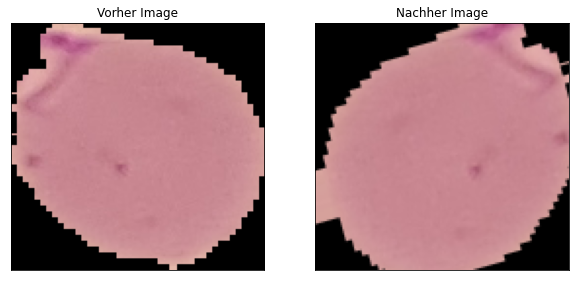

In [ ]:
example_infected_cell = np.random.choice(infected_files)

plt.figure(1, figsize = (10 , 7))

# Originalbild 
plt.subplot(1 , 2 , 1)   # das sagt in Zeile 1 2 Bilder und jetzt wird das erste geplottet
img = plt.imread(example_infected_cell)
plt.imshow(img)
plt.title('Vorher Image')
plt.xticks([]) , plt.yticks([])

# Bild nachher 
plt.subplot(1 , 2 , 2) # das sagt in Zeile 1 2 Bilder und jetzt wird das zweite geplottet
modified_img = plt.imread(example_infected_cell)
plt.imshow(train_image_gen.random_transform(modified_img))
plt.title('Nachher Image')
plt.xticks([]) , plt.yticks([])

## Simples Convolutional Neural Network

In [ ]:
import tensorflow as tf
import tensorflow.keras   # Keras als Schnittstelle zu den "komplizierteren Umfängen"
from tensorflow.keras import layers
from tensorflow.keras import Model

INPUT_SHAPE = (150, 150, 3)

inp = tf.keras.layers.Input(shape=INPUT_SHAPE)

conv1 = tf.keras.layers.Conv2D(32, 
                               kernel_size=(3, 3), 
                               activation='relu',
                               padding='same')(inp)


pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1) 

drop1 = tf.keras.layers.Dropout(0.3) (pool1)

conv2 = tf.keras.layers.Conv2D(64, 
                               kernel_size=(3, 3), 
                               activation='relu',
                               padding='same') (drop1)

pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
drop2 = tf.keras.layers.Dropout(0.3) (pool2)

conv3 = tf.keras.layers.Conv2D(128, 
                               kernel_size=(3, 3), 
                               activation='relu', 
                               padding='same')(drop2)
                               
pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

flat = tf.keras.layers.Flatten()(pool3)

hidden1 = tf.keras.layers.Dense(512, activation='relu')(flat)

drop4 = tf.keras.layers.Dropout(rate=0.5)(hidden1)

hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop4)

drop5 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop5)



model = tf.keras.Model(inputs=inp, outputs=out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37, 37, 64)        0     

Hier definieren wir die folgenden Hyperparameter:
* Batch_size: wie viele Samples werden aus der Trainingsmenge genommen bevor die Gewichte und Bias des Modells angepaßt werden. Im unteren Fall heißt das, nach 256 Bildern passen wir die Gewichte an.
* Epochen: wie viele Durchläufe durch das gesamte Datenset werden gemacht.
* Learning_rate: Geschwindigkeit mit der das Modell lernt. Genauer gesagt stellt es die Schrittweite dar, die bei jeder Iteration gegangen wird, um das Minimum der Loss-Funktion zu erreichen.
* Optimizer: Algorithmus der eingesetzt wird, um die Gewichte und Bias so zu reduzieren, daß die Loss-Funktion minimiert wird.

Diese Parameter ermöglichen deutliche Verbesserungen des Ergebnisses und  stehen auch miteinander in Verbindung (bspw. small batch size sollte mit niedriger Lernrate kombiniert werden).


Nachdem wir das gemacht haben, starten wir das Trainieren des Models.

In [ ]:
BATCH_SIZE = 256
EPOCHS = 10 # nur 10 Epochen, damit schnell fertig für kurzen Test

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='binary_crossentropy', 
              optimizer=opt, 
              metrics=['accuracy'])

history = model.fit(
    train_generator,  # lade die Daten/ Bilder aus dem Train_Generator
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    #steps_per_epoch = len(train_generator.filenames) // (BATCH_SIZE),  # wenn wir den Parameter per Kommentar auskommentieren, wird standardmäßig was berechnet
    validation_data=validation_generator,  # lade die Validation Data aus dem Validation Generator
    #validation_steps=len(validation_generator.filenames) // (BATCH_SIZE)
    )

Epoch 1/10
65/65 [==============================] - 120s 2s/step - loss: 0.6521 - accuracy: 0.6180 - val_loss: 0.5340 - val_accuracy: 0.7745
Epoch 2/10
65/65 [==============================] - 114s 2s/step - loss: 0.3313 - accuracy: 0.8839 - val_loss: 0.2057 - val_accuracy: 0.9309
Epoch 3/10
65/65 [==============================] - 113s 2s/step - loss: 0.2115 - accuracy: 0.9281 - val_loss: 0.1770 - val_accuracy: 0.9418
Epoch 4/10
65/65 [==============================] - 113s 2s/step - loss: 0.1864 - accuracy: 0.9399 - val_loss: 0.1609 - val_accuracy: 0.9536
Epoch 5/10
65/65 [==============================] - 113s 2s/step - loss: 0.1745 - accuracy: 0.9463 - val_loss: 0.1531 - val_accuracy: 0.9548
Epoch 6/10
65/65 [==============================] - 112s 2s/step - loss: 0.1612 - accuracy: 0.9491 - val_loss: 0.1620 - val_accuracy: 0.9546
Epoch 7/10
65/65 [==============================] - 113s 2s/step - loss: 0.1628 - accuracy: 0.9474 - val_loss: 0.1450 - val_accuracy: 0.9561
Epoch 8/10
65

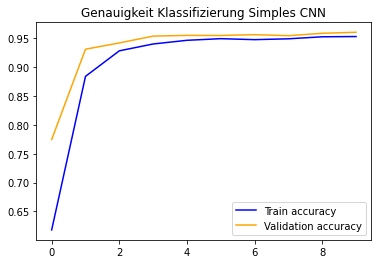

In [ ]:
# Plotte Genauigkeit
plt.title('Genauigkeit Klassifizierung Simples CNN')
plt.plot(history.history['accuracy'], color='blue', label='Train accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='Validation accuracy')
plt.legend()
plt.show()

In [ ]:
model.save('basic_malaria_model.h5')

## Transfer Learning

Die Genauigkeit von Deep Learning Verfahren hängt von der Größe und der Datenqualität der Trainingsmenge ab sowie von der - oft durch Ausprobieren- verwendeten Struktur des CNN-Netzes. 

An dieser Stelle ermöglicht Transfer Learning deutliche Zeitersparnis und Effizienzgewinne durch das Verwenden eines schon auf Millionen von Daten vortrainierten Modells. 

Die Idee von Transfer Learning ist genauer gesagt, alle Elemente des vortrainierten Modells bis auf die letzten 1-2 Schichten direkt zu übernehmen und dann die letzten beiden Schichten (meist aber nur die letzte Schicht) auf das vorliegende Problem anzupassen und dann das modifizierte Modell auf die Traningsmenge erneut zu trainieren.

Es gibt viele vortrainierte Modelle, die bekanntesten sind aber folgende:

| Model  |Größe |	Top-1 Accuracy | Top-5 Accuracy	| Parameter | Tiefe |
|------  |-----|----------------|----------------|------------|-------|
|Xception|	88 MB |	0.790 |	0.945 |	22,910,480	|126|
|VGG16 | 528 MB |	0.713 |	0.901 |	138,357,544 |23|
|VGG19 | 549 MB	|0.713	|0.900	|143,667,240 |	26|
|ResNet50| 	98 MB|	0.749|	0.921 |	25,636,712 |	-|
|ResNet101|	171 MB|	0.764|	0.928|	44,707,176	|-|
|ResNet152|	232 MB|	0.766|	0.931|	60,419,944	|-|
|ResNet50V2|	98 MB|	0.760|	0.930|	25,613,800	|-|
|ResNet101V2|	171 MB|	0.772|	0.938|	44,675,560|	-|
|ResNet152V2|	232 MB|	0.780|	0.942|	60,380,648|	-|
|ResNeXt50|	96 MB|	0.777|	0.938|	25,097,128|	-|
|ResNeXt101|	170 MB|	0.787|	0.943|	44,315,560|	-|
|InceptionV3|	92 MB|	0.779|	0.937|	23,851,784|	159|
|InceptionResNetV2|	215 MB|	0.803|	0.953|	55,873,736|	572|
|MobileNet|	16 MB|	0.704|	0.895|	4,253,864|	88|
|MobileNetV2|	14 MB|	0.713|	0.901|	3,538,984|	88|
|DenseNet121|	33 MB|	0.750|	0.923|	8,062,504|	121|
|DenseNet169|	57 MB|	0.762|	0.932|	14,307,880|	169|
|DenseNet201|	80 MB|	0.773|	0.936|	20,242,984|	201|
|NASNetMobile|	23 MB|	0.744|	0.919|	5,326,716|	-|
|NASNetLarge|	343 MB|	0.825|	0.960|	88,949,818|	-|

Allgemeine Erklärung der Spalten:
* Top1- und Top5-Genauigkeit bezieht sich auf die Performance des Modells beim  ImageNet validation dataset.
* Parameters: je mehr Parameter, desto mehr Zeit zum Lernen wird benötigt.
* Tiefe: je tiefer, desto mehr Zeit wird zum Lernen benötigt

Wir setzen für den weiteren Verlauf das [VGG16](https://arxiv.org/pdf/1409.1556) sowie [MobileNet](https://arxiv.org/pdf/1704.04861.pdf) ein. Beide benötigtem als Input-Format für Bilder 224x224x3 weshalb wir die Bilder per ImageDataGen anpassen.

Das Einsetzen von anderen Transfer Learning-Modellen geschieht analog.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_image_gen_VGG = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

test_image_gen_VGG = ImageDataGenerator(rescale=1./255)

train_generator_VGG = train_image_gen_VGG.flow_from_directory(
    "/content/output/train", 
    target_size=(224, 224),  
    color_mode = 'rgb',
    batch_size=64,  
    class_mode='binary',
    shuffle=True)

validation_generator_VGG = test_image_gen_VGG.flow_from_directory(
    "/content/output/val", 
    target_size=(224, 224),
    batch_size=64,  
    color_mode = 'rgb',
    class_mode='binary',
    shuffle=True)

Found 16534 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.


### VGG 16

VGG16 ([Detailinfos](https://arxiv.org/abs/1409.1556)) hat folgende Struktur:

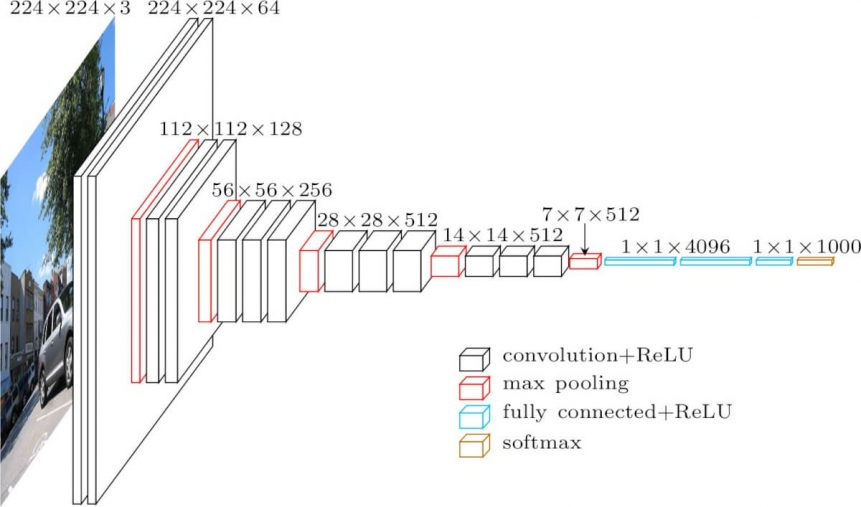
Quelle: [Link](https://neurohive.io/en/popular-networks/vgg16/)

Schaut man sich die ganze Struktur als Sequenzdiagram an, sieht sie wie folgt aus:

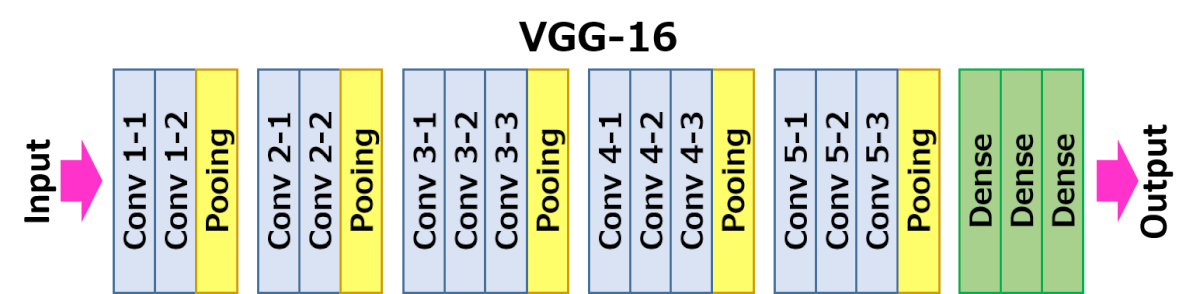 Quelle: [Link](https://neurohive.io/en/popular-networks/vgg16/)

Die Idee vom Transfer Learning ist nun, daß wir die Bilderkennung in den ersten Schichten übernehmen, aber an die bestehenden Schichten des Klassifikators (grüne Farbe) einen eigenen Klassifikator ersetzen. Alternativ kann man auch die grünen Schichten ersetzen durch einen eigenen Klassifikator.

Weiterhin sorgen wir dafür, daß bei der Backpropagation nur die Schichten unseres Klassifikators angepaßt werden und **nicht** die Schichten für die Bilderkennung. 

In [ ]:
import tensorflow as tf
import tensorflow.keras   # Keras als Schnittstelle zu den "komplizierteren Umfängen"
from tensorflow.keras import layers
from tensorflow.keras import Model

vgg_new = tf.keras.applications.vgg19.VGG19(
    include_top=False, 
    weights='imagenet', 
    input_shape=(224, 224, 3))

base_vgg_new = vgg_new
base_out_new = base_vgg_new.output  # speichern des letzten Layers des VGG16 in base_out_new. Hier kommen die neuen Layer dran

# ab hier hängen wir weitere Schichten an das Modell an. Das Ziel ist dabei das Modell auf unseren Anwendungsfall anzupassen
flatten = tf.keras.layers.Flatten()(base_out_new)
out = tf.keras.layers.Dense(1, activation='sigmoid')(flatten)  # wir haben ja nur 2 Klassen (infiziert/ gesund)

# koppeln altes modell mit gerade definierten Schichten
VGG_model_new = tf.keras.Model(inputs=base_vgg_new.input, outputs=out)

VGG_model_new.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-5), 
                loss='binary_crossentropy',
                metrics=['accuracy'])

# explizit setzen aller Schichten auf nicht trainierbar.
for layer in VGG_model_new.layers:
  layer.trainable = False

# aber der letzte, neu hinzugefügte Layer, ist trainierbar. Sonst hätte das ganze ja nichts gebracht
for layer in VGG_model_new.layers[-1:]:
  layer.trainable = True

print("Total Layers:", len(VGG_model_new.layers))
print("Total trainable layers:", sum([1 for l in VGG_model_new.layers if l.trainable]))

80150528/80134624 [==============================] - 1s 0us/step
Total Layers: 24
Total trainable layers: 1


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
VGG_model_new.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

Man sieht die neue Struktur. Die Layer sind bis auf die letzten 2 Zeilen der Tabelle vom VGG16, die letzten beiden - Flatten 1 und dense_3 - sind neu hinzugekommen. Diese trainieren wir jetzt, damit das gesamte Netz auf Erkennen von Malaria-Zellen angepaßt wird. 
Wir trainieren also die 25089 Parameter aus der letzten Zeile auf Malaria.

In [ ]:
BATCH_SIZE = 256
EPOCHS = 10  # 

# Überwachungsfunktion, die Training abbricht sobald mehr als 5 Runden hintereinander die Val_acc nicht hochgeht. Bei nur 10 Epochs Training bringt das aber nicht soo viel....
#earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=5, verbose=0, mode='min')

# Speichere immer nur das Modell
#mcp_save = tf.keras.callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_accuracy', mode='min')

historyVGG = VGG_model_new.fit(
    train_generator_VGG, 
    epochs=EPOCHS,
    validation_data=validation_generator_VGG
    #callbacks=[earlyStopping, mcp_save]
    )

Epoch 1/10
259/259 [==============================] - 550s 2s/step - loss: 0.1508 - accuracy: 0.9491 - val_loss: 0.1465 - val_accuracy: 0.9485
Epoch 2/10
259/259 [==============================] - 547s 2s/step - loss: 0.1295 - accuracy: 0.9565 - val_loss: 0.1194 - val_accuracy: 0.9604
Epoch 3/10
259/259 [==============================] - 549s 2s/step - loss: 0.1205 - accuracy: 0.9599 - val_loss: 0.1071 - val_accuracy: 0.9634
Epoch 4/10
259/259 [==============================] - 550s 2s/step - loss: 0.1120 - accuracy: 0.9615 - val_loss: 0.0973 - val_accuracy: 0.9653
Epoch 5/10
259/259 [==============================] - 548s 2s/step - loss: 0.1076 - accuracy: 0.9626 - val_loss: 0.1146 - val_accuracy: 0.9668
Epoch 6/10
259/259 [==============================] - 545s 2s/step - loss: 0.1015 - accuracy: 0.9638 - val_loss: 0.0955 - val_accuracy: 0.9690
Epoch 7/10
259/259 [==============================] - 547s 2s/step - loss: 0.0962 - accuracy: 0.9674 - val_loss: 0.1042 - val_accuracy: 0.9695

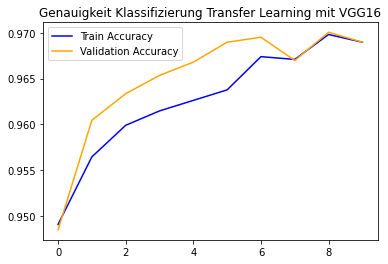

In [ ]:
# Plotte Genauigkeit
plt.title('Genauigkeit Klassifizierung Transfer Learning mit VGG16')
plt.plot(historyVGG.history['accuracy'], color='blue', label='Train Accuracy')
plt.plot(historyVGG.history['val_accuracy'], color='orange', label='Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
VGG_model_new.save('vgg_augmented_data.h5')

### MobileNet

Wir nehmen für MobileNet die gleichen Train-, Test- und Validation-Generator wie für VGG16, um Ressourcen zu sparen.

In [ ]:
baseModelMobile = tf.keras.applications.MobileNetV2(
    include_top=False, 
    weights='imagenet', 
    input_shape=(224, 224, 3))

# wir fügen 1 layer hinzu um unsere eigene Klassifikation zu machen
base_out = baseModelMobile.output
flatten = tf.keras.layers.Flatten()(base_out)
out = tf.keras.layers.Dense(1, activation='sigmoid')(flatten)

MobileNet = tf.keras.Model(inputs=baseModelMobile.input, outputs=out)  

print("Total Layers:", len(MobileNet.layers))
print("Total trainable layers:", sum([1 for l in MobileNet.layers if l.trainable]))

MobileNet.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-5),
                loss='binary_crossentropy',
                metrics=['accuracy'])

# explizit setzen aller Schichten auf nicht trainierbar.
for layer in MobileNet.layers:
  layer.trainable = False

# aber der letzte, neu hinzugefügte Layer, ist trainierbar. Sonst hätte das ganze ja nichts gebracht
for layer in MobileNet.layers[-1:]:
  layer.trainable = True

print("Total Layers:", len(MobileNet.layers))
print("Total trainable layers:", sum([1 for l in MobileNet.layers if l.trainable]))

9420800/9406464 [==============================] - 0s 0us/step
Total Layers: 156
Total trainable layers: 156
Total Layers: 156
Total trainable layers: 1


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
MobileNet.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [ ]:
historyMobileNet = MobileNet.fit(
    train_generator_VGG, 
    epochs=EPOCHS,
    validation_data=validation_generator_VGG
 #   callbacks=[earlyStopping, mcp_save]
    )

Epoch 1/10
259/259 [==============================] - 307s 1s/step - loss: 0.4129 - accuracy: 0.8170 - val_loss: 0.7120 - val_accuracy: 0.5914
Epoch 2/10
259/259 [==============================] - 273s 1s/step - loss: 0.2238 - accuracy: 0.9173 - val_loss: 0.5508 - val_accuracy: 0.7032
Epoch 3/10
259/259 [==============================] - 275s 1s/step - loss: 0.1816 - accuracy: 0.9366 - val_loss: 0.4126 - val_accuracy: 0.8077
Epoch 4/10
259/259 [==============================] - 274s 1s/step - loss: 0.1742 - accuracy: 0.9401 - val_loss: 0.3231 - val_accuracy: 0.8723
Epoch 5/10
259/259 [==============================] - 274s 1s/step - loss: 0.1590 - accuracy: 0.9450 - val_loss: 0.2610 - val_accuracy: 0.8953
Epoch 6/10
259/259 [==============================] - 274s 1s/step - loss: 0.1468 - accuracy: 0.9476 - val_loss: 0.2635 - val_accuracy: 0.8959
Epoch 7/10
259/259 [==============================] - 275s 1s/step - loss: 0.1455 - accuracy: 0.9503 - val_loss: 0.2643 - val_accuracy: 0.8999

In [ ]:
# Plotte Genauigkeit
plt.title('Genauigkeit Klassifizierung Transfer Learning mit MobileNet')
plt.plot(historyMobileNet.history['accuracy'], color='blue', label='Train Accuracy')
plt.plot(historyMobileNet.history['val_accuracy'], color='orange', label='Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
MobileNet.save('MobileNet_augmented_data.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Modellgüte testen

In [ ]:
basic_cnn = tf.keras.models.load_model('./basic_malaria_model.h5')
vgg_augmented = tf.keras.models.load_model('./vgg_augmented_data.h5')
mobile_augmented = tf.keras.models.load_model('./MobileNet_augmented_data.h5')

In [ ]:
# basic_cnn_preds = basic_cnn.predict(test_imgs_scaled, batch_size=256)
# vgg_aug_preds = vgg_augmented.predict(test_imgs_scaled, batch_size=256)

loss_Basic_CNN, accuracy_Basic_CNN = basic_cnn.evaluate(test_generator)
print('Test accuracy :', accuracy_Basic_CNN)

22/22 [==============================] - 8s 341ms/step - loss: 0.1336 - accuracy: 0.9554
Test accuracy : 0.9553701281547546


Hier testen wir die einzelnen Modelle inkl. Testgenerators.

In [ ]:
test_generator_VGG = test_image_gen_VGG.flow_from_directory(
     "/content/output/test", 
     target_size=(224, 224),
     batch_size=32,
     color_mode = 'rgb',
     class_mode='binary',
     shuffle=True)

loss_VGG, accuracy_VGG = vgg_augmented.evaluate(test_generator_VGG)
print('Test accuracy :', accuracy_VGG)

Found 5512 images belonging to 2 classes.
173/173 [==============================] - 62s 297ms/step - loss: 0.0995 - accuracy: 0.9692
Test accuracy : 0.9691581726074219


In [ ]:
# mobileNet
test_generator_mobile_net = test_image_gen_VGG.flow_from_directory(
     "/content/output/test", 
     target_size=(224, 224),
     batch_size=64,
     color_mode = 'rgb',
     class_mode='binary',
     shuffle=True)

loss_MobileNet, accuracy_MobileNet = MobileNet.evaluate(test_generator_mobile_net)
print('Test accuracy :', accuracy_MobileNet)

Found 5512 images belonging to 2 classes.
87/87 [==============================] - 14s 161ms/step - loss: 0.1777 - accuracy: 0.9394
Test accuracy : 0.9394049644470215


## Modell anwenden

Wie funktioniert ein Einsatz des Modells nachher?
Bei einem "realen" Einsatz würde das Modell in der Cloud oder Handy gespeichert bzw. "deployed" werden.

Das Modell erhält dann ein/ mehrere Bilder als Input und berechnet eine prozentuale Zahl, die ausdrückt, zu welcher der Zielklassen das Bild gehört.
Da wir nur 2 Zielklassen haben, ist der Schwellwert für die Zuordnung bei 50%.

In [ ]:
print(test_generator.class_indices)
print(test_generator_VGG.class_indices)

{'Parasitized': 0, 'Uninfected': 1}
{'Parasitized': 0, 'Uninfected': 1}


### Vorhersage mehrerer Bilder

Hier Code für mehrere Bilder mit Einsatz des einfachen CNN

In [ ]:
import matplotlib.image as mpimg

test_generator.reset()    

cnn_pred_labels = model.predict(test_generator,1000)

print("Predictions finished")
print(len(cnn_pred_labels))

Predictions finished
5512


Parasitized/C100P61ThinF_IMG_20150918_144104_cell_163.png
Parasitized/C130P91ThinF_IMG_20151004_142709_cell_126.png
Parasitized/C170P131ThinF_IMG_20151119_120111_cell_229.png
Parasitized/C184P145ThinF_IMG_20151203_104334_cell_17.png
Parasitized/C60P21thinF_IMG_20150804_105955_cell_133.png
Parasitized/C91P52ThinF_IMG_20150821_123116_cell_199.png
Uninfected/C117P78ThinF_IMG_20150930_215322_cell_75.png
Uninfected/C152P113ThinF_IMG_20151115_124323_cell_28.png
Uninfected/C188P149ThinF_IMG_20151203_134449_cell_85.png
Uninfected/C237ThinF_IMG_20151127_104748_cell_88.png
Uninfected/C64P25N_ThinF_IMG_20150818_153517_cell_49.png
Uninfected/C98P59ThinF_IMG_20150917_154235_cell_20.png


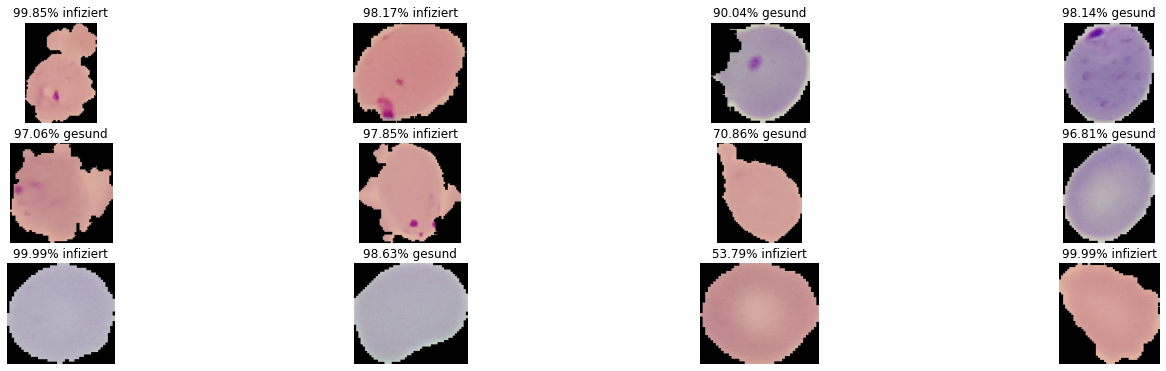

In [ ]:
# oder anderes Modell als Basis nehmen
number_cols = 4
number_rows = len(cnn_pred_labels) // 500
run_index = 0

plt.figure(1 , figsize = (24, 24))

for index, probability in enumerate(cnn_pred_labels):
    # nur jedes 500. Bild plotten, sonst zu viele Bilder
    if index % 500 == 0:
      run_index += 1
      cur_plot = plt.subplot(number_rows, number_cols, run_index)

      image_path = '/content/output/test/' + test_generator.filenames[index]
      img = mpimg.imread(image_path)
    
      plt.imshow(img)
      print(test_generator.filenames[index])
      if probability > 0.5:
        plt.title("%.2f" % (probability[0]*100) + "% gesund")
      else:
        plt.title("%.2f" % ((1-probability[0])*100) + "% infiziert")
    #plt.show()
    cur_plot.axis('Off') # Keine Achsen zeigen
  
plt.show()

### Vorhersage eines Bildes

Hier der Code für Vorhersage eines Bildes mit MobileNet

In [ ]:
from keras.preprocessing import image

def classify_pic(imagePath):
  img = image.load_img(imagePath, target_size=(224, 224))
  img_tensor = image.img_to_array(img)                    # (Höhe, Breite, Kanäle = RGB)
  img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, Höhe, Breite, Kanäle), und eine dimension dazufügen. Erwartet wird folgende Struktur: (batch_size, height, width, channels)
  img_tensor /= 255.                                      # Bild normalisieren

  predictions_single = MobileNet.predict(img_tensor)
  
  # aus einer vorherigen Zeile wissen wir, daß parasitäre Zellen den class_index 0 haben.
  if predictions_single <= 0.5:
    print("{} ist infiziert".format(imagePath))
  else:
    print("{} ist gesund".format(imagePath))

  print("mit Genauigkeit von {}%".format(probability[0]*100))

  plt.imshow(img)
  cur_plot.axis('Off') # Keine Achsen zeigen
  plt.show()

/content/output/test/Uninfected/C100P61ThinF_IMG_20150918_144104_cell_21.png ist gesund
mit Genauigkeit von 98.80461692810059%


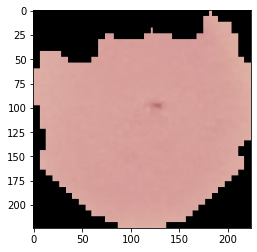

In [ ]:
classify_pic("/content/output/test/Uninfected/C100P61ThinF_IMG_20150918_144104_cell_21.png")

## Explainability

Explainability bezeichnet die Eigenschaft einess Machine Learning Modells, zu erklären, wieso es zu einer Ausgabe kam; oder in unserem Fall: wieso es eine Zelle als infiziert erkennt.

Diese Fähigkeit ist für Machine Learning Modelle sehr relevant in sicherheitsrelevanten Einsatzgebieten (bspw. autonomes Fahren: wieso hat das Fahrzeug gebremst? Oder gar nicht gebremst?) sowie bei Root Cause/ Diagnoseanalysen (bspw. was ist die Ursache für einen Fehler? Wieso diese Krankheit?).

Leider ist es aufgrund der Struktur von Neuronalen Netzen die Explainability eher schwer. Dies liegt nicht nur an den vielen, vielen möglichen Hidden Layers, sondern auch an der Verknüpfung der einzelnen Layer miteinander.

In diesem Abschnitt wollen wir uns deshalb über bildliche Analyse anschauen, wie ein Input-Bild durch die Schichten des Netzes durchgereicht wird und was jeweils in den Schichten erkannt wird.



### Explainability für CNN

Wir schauen uns die Explainability zuerst für das simple CNN an, da es deutlich weniger Layer hat als die Transfer Learning Modelle.

Der Code basiert dabei auf [Link](https://towardsdatascience.com/convolutional-neural-network-feature-map-and-filter-visualization-f75012a5a49c).

Wir bauen im ersten Schritt ein Modell für die Visualisierung

In [ ]:
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

[<KerasTensor: shape=(None, 150, 150, 32) dtype=float32 (created by layer 'conv2d')>,
 <KerasTensor: shape=(None, 75, 75, 32) dtype=float32 (created by layer 'max_pooling2d')>,
 <KerasTensor: shape=(None, 75, 75, 32) dtype=float32 (created by layer 'dropout')>,
 <KerasTensor: shape=(None, 75, 75, 64) dtype=float32 (created by layer 'conv2d_1')>,
 <KerasTensor: shape=(None, 37, 37, 64) dtype=float32 (created by layer 'max_pooling2d_1')>,
 <KerasTensor: shape=(None, 37, 37, 64) dtype=float32 (created by layer 'dropout_1')>,
 <KerasTensor: shape=(None, 37, 37, 128) dtype=float32 (created by layer 'conv2d_2')>,
 <KerasTensor: shape=(None, 18, 18, 128) dtype=float32 (created by layer 'max_pooling2d_2')>,
 <KerasTensor: shape=(None, 41472) dtype=float32 (created by layer 'flatten')>,
 <KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'dense')>,
 <KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'dropout_2')>,
 <KerasTensor: shape=(None, 512) dtype=float32 (created

Jetzt passen wir ein Bild an das Format des "neuen" CNN an und jagen es durch das CNN

In [ ]:
img = image.load_img("/content/output/test/Uninfected/C100P61ThinF_IMG_20150918_144104_cell_21.png", target_size=(150, 150))
img_tensor = image.img_to_array(img)                    # (Höhe, Breite, Kanäle = RGB)
img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, Höhe, Breite, Kanäle), und eine dimension dazufügen. Erwartet wird folgende Struktur: (batch_size, height, width, channels)
img_tensor /= 255.                                      # Bild normalisieren

successive_feature_maps = visualization_model.predict(img_tensor)

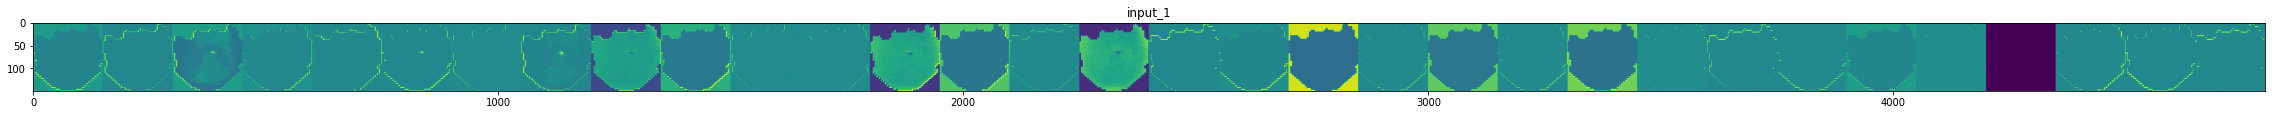

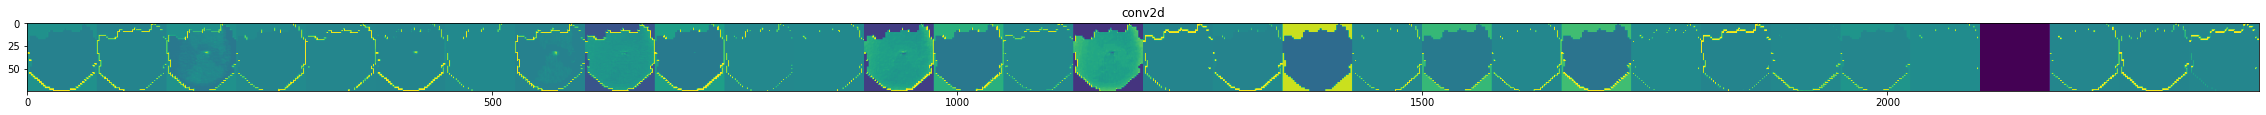

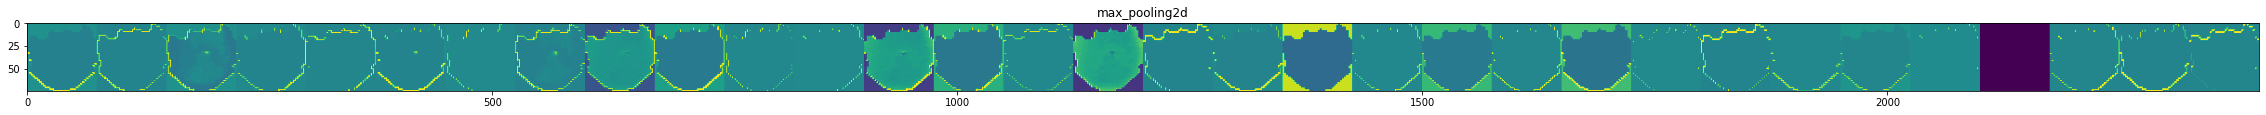

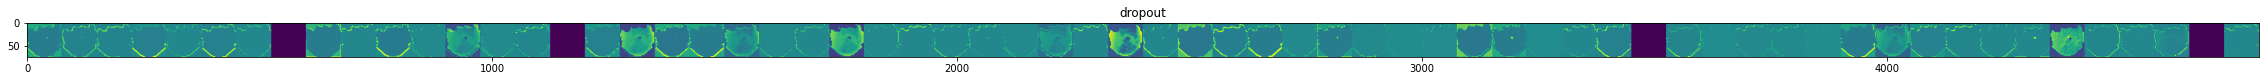

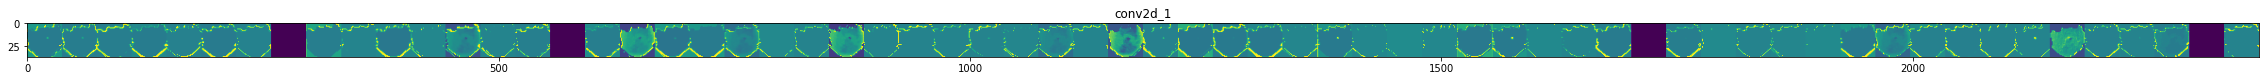

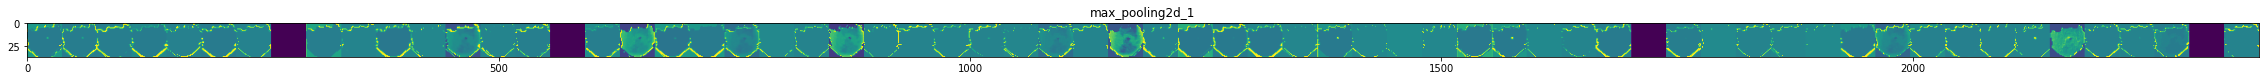

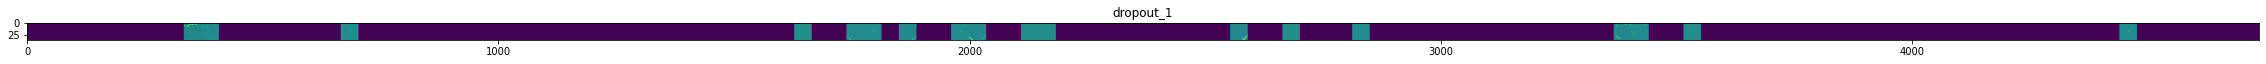

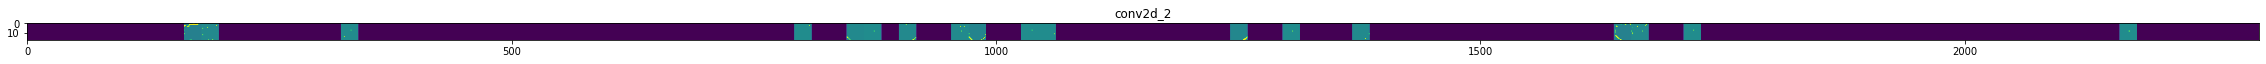

In [ ]:
# Retrieve are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    
    # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    # Postprocess the feature to be visually palatable
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      # Tile each filter into a horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x

    # Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features * 2, scale * 2) )
    #plt.figure( figsize=(8, 8) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )

### Explainability für VGG16

Schauen wir uns die Explainability am Beispiel von VGG16-Modell an, um die interessanten Abschnitte zu finden für eine Visualisierung. 

Der Code ist entnommen aus [Link](https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/)

In [ ]:
VGG_16_model = tf.keras.applications.vgg16.VGG16() # load the model

# redefine model to output right after the first hidden layer
ixs = [2, 5, 9, 13, 17]

outputs = [VGG_16_model.layers[i].output for i in ixs]
VGG_16_model = Model(inputs=VGG_16_model.inputs, outputs=outputs)

# load the image with the required shape
img = load_img("/content/output/test/Uninfected/C100P61ThinF_IMG_20150918_144104_cell_21.png", target_size=(224, 224))
img = img_to_array(img) # convert the image to an array
img = expand_dims(img, axis=0) # expand dimensions so that it represents a single 'sample'
img = preprocess_input(img) # prepare the image (e.g. scale pixel values for the vgg)

# put image into model and get feature map for first hidden layer
feature_maps = VGG_16_model.predict(img)

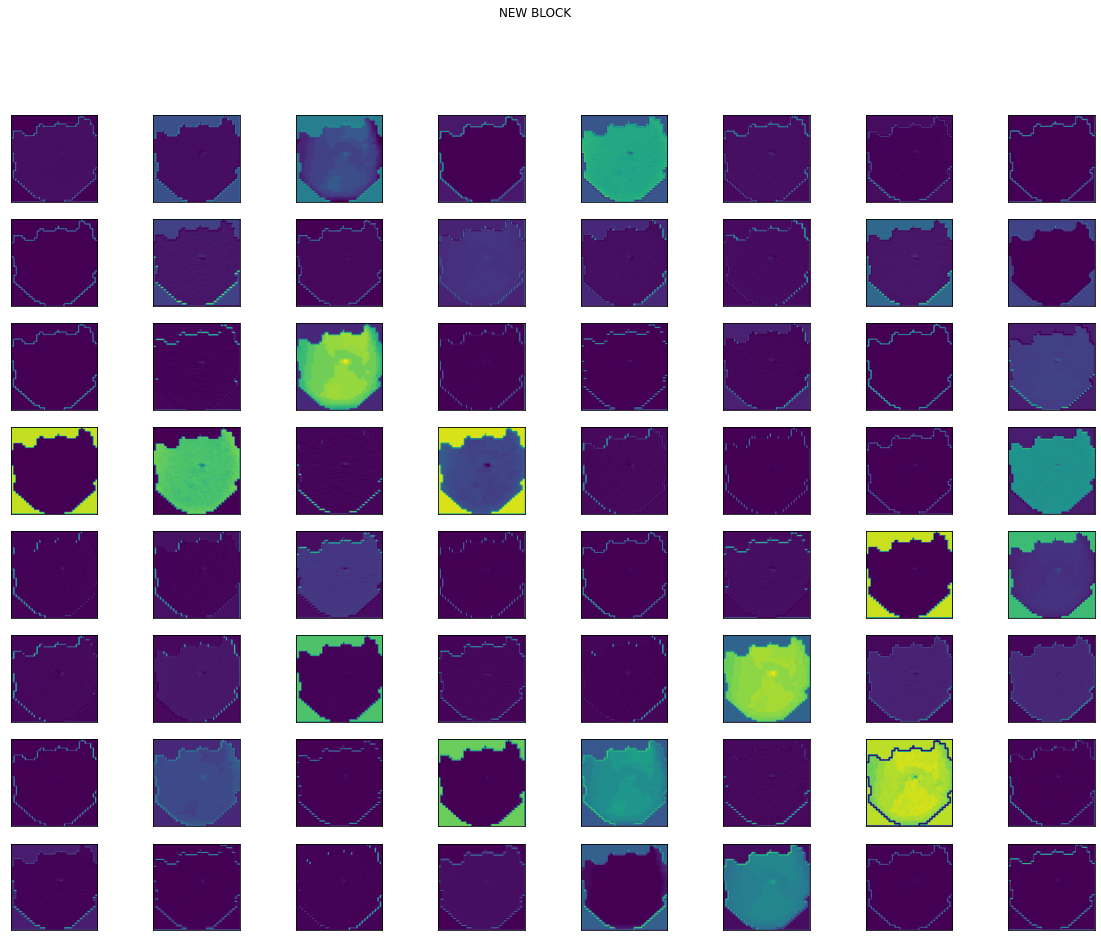

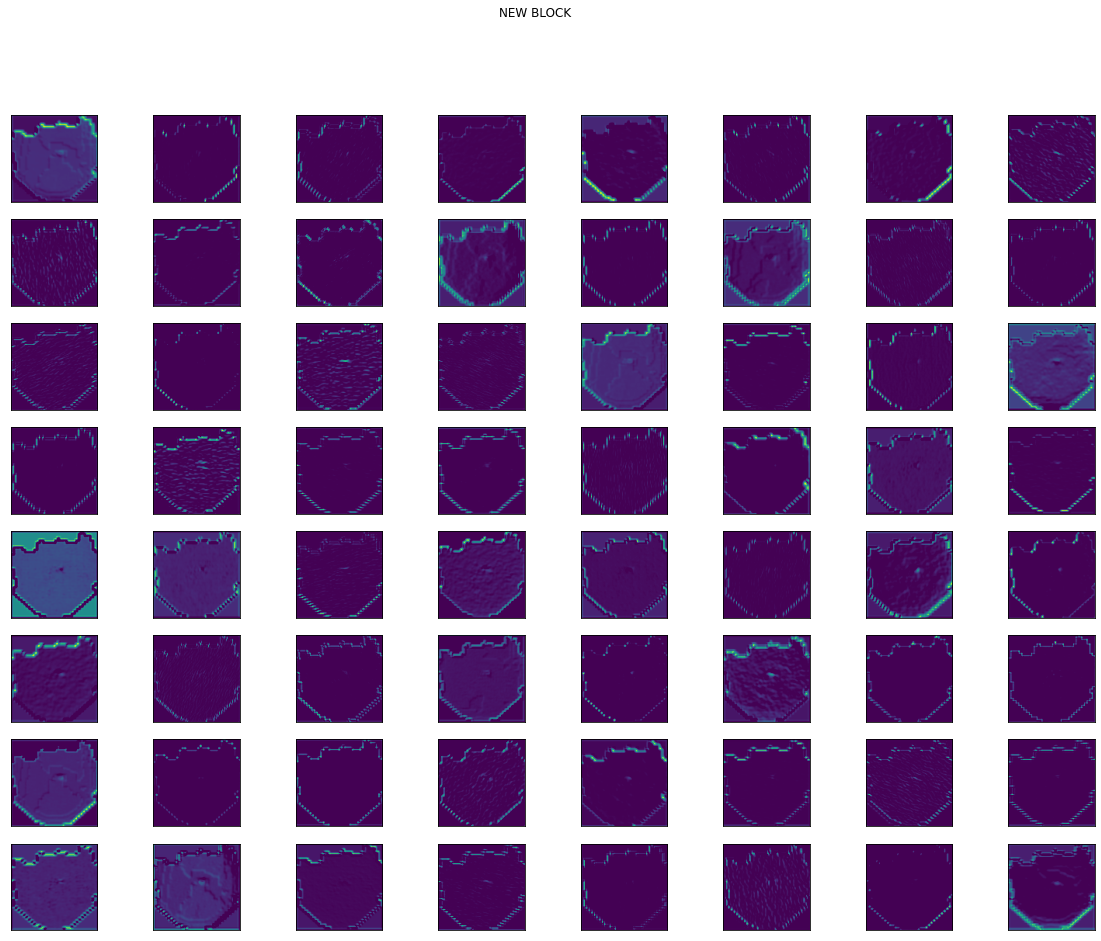

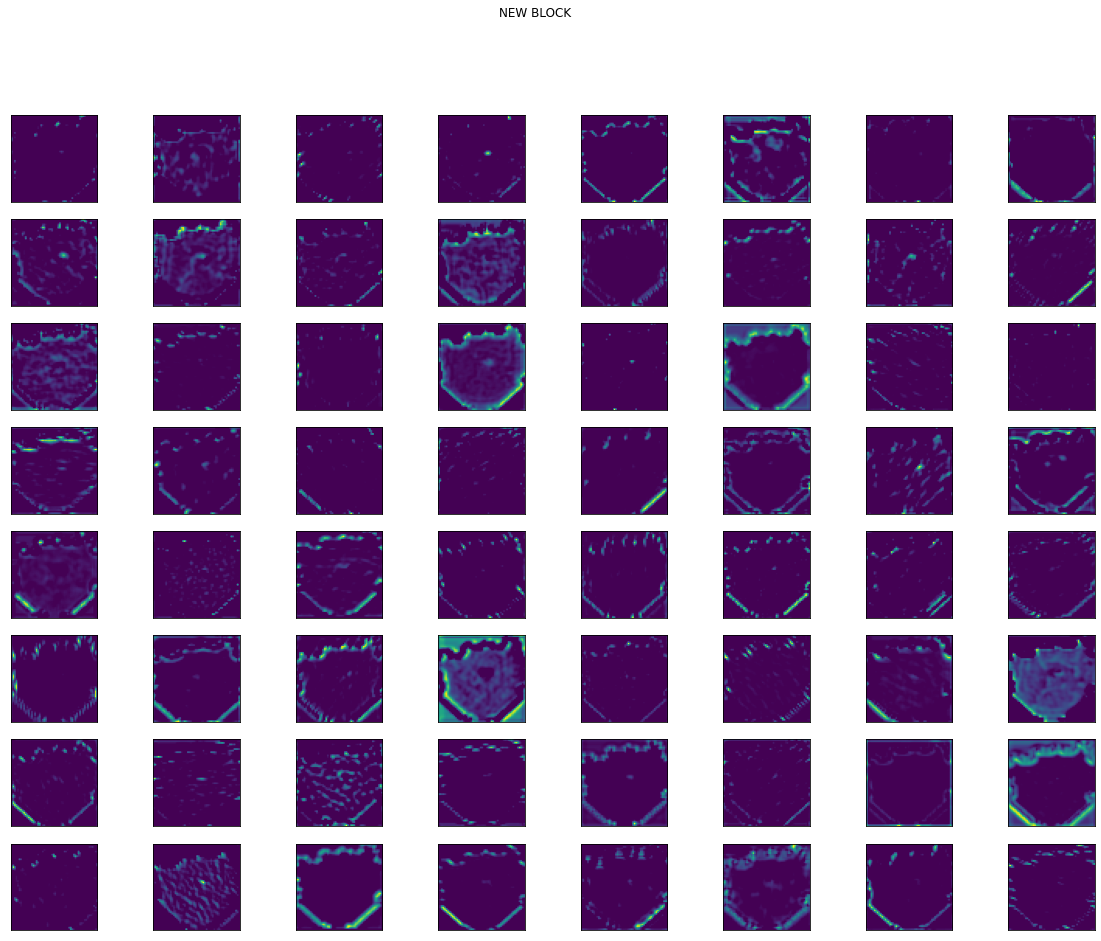

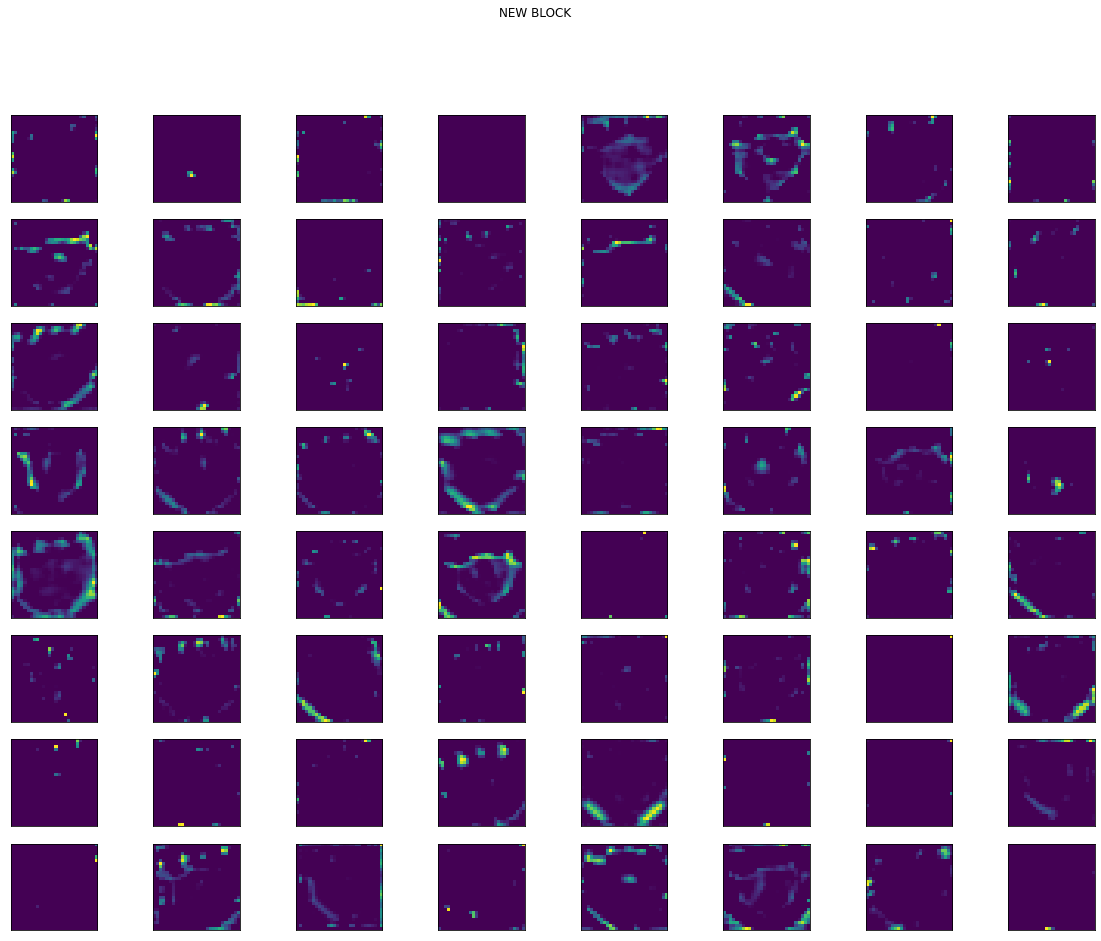

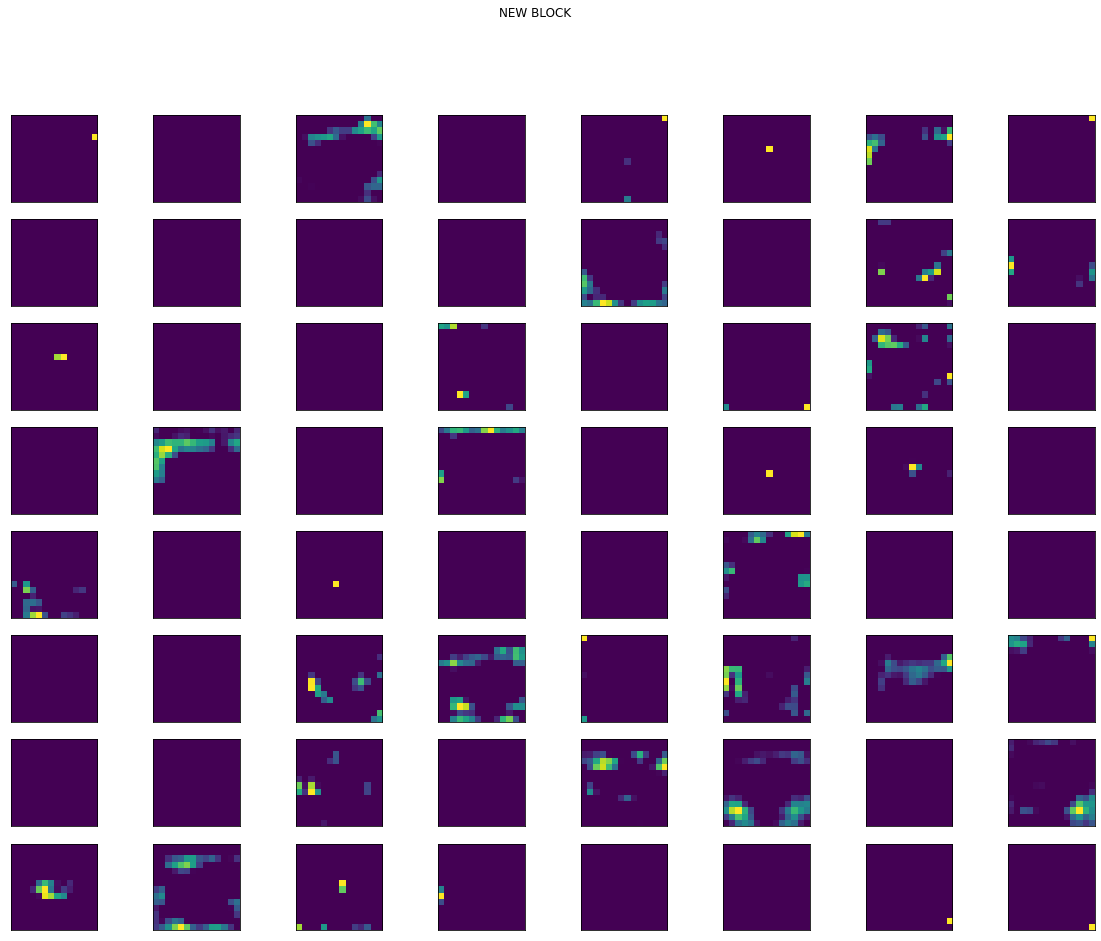

In [ ]:
# plot the output from each block in 8x8
square = 8
for fmap in feature_maps:
  # plot all 64 maps in an 8x8 squares
  ix = 1
  fig = plt.figure(figsize=(20,15))
  fig.suptitle("NEW BLOCK", fontsize=12)
  
  for _ in range(square):
    for _ in range(square):
      # specify subplot and turn of axis
      ax = plt.subplot(square, square, ix)
      ax.set_xticks([])
      ax.set_yticks([])
      # plot filter channel in grayscale
      plt.imshow(fmap[0, :, :, ix-1], cmap='viridis')
      ix += 1
  # show the figure
  plt.show()